In [16]:
# coding: utf-8    #  par défaut l'encoding est en utf-8 pour python 3

# Import des librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pylab
import re

import nltk
import spacy

import time
from datetime import date

In [17]:
# Changer la taille de police par défaut
plt.rcParams.update({'font.size': 15})

pd.set_option('display.max_row', 500)
pd.set_option('display.max_column', 400)
pd.set_option('display.column_space', 200)
pd.set_option('display.width', 10000)   # pas encore essay

In [18]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 50

<IPython.core.display.Javascript object>

# Chargement des données

In [43]:
flipkart = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")
print("Shape produits = ", flipkart.shape)

Shape produits =  (1050, 15)


In [44]:
# Nettoyage colonnes

flipkart = flipkart.drop(['uniq_id','crawl_timestamp','product_url','pid', 'retail_price','discounted_price',
                          'is_FK_Advantage_product','product_rating','overall_rating','brand','product_specifications'], 1)

# ... et renommage
flipkart.columns = ['product', 'category', 'image', 'description']
flipkart.head(2)

,product,category,image,description
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...


In [45]:
# Récupération de la catégorie de 1er niveau pour chaque produit

import string

def get_first_categ(categories):
    deb = categories.find('\"')            # indice du 1er caractère '#'
    fin = categories.find('>')             # indice du 1er caractère '>'
    first_categ = categories[deb+1:fin-1]  # La 1ere catégorie est entre les deux indices
    first_categ.rstrip()                   # sup espace en fin de chaine
    return(first_categ)

flipkart['category'] = flipkart['category'].apply(get_first_categ)

flipkart.head(3)

,product,category,image,description
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...
1,Sathiyas Cotton Bath Towel,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...
2,Eurospa Cotton Terry Face Towel Set,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...


In [46]:
# Nombre de caractères Min et Max des descriptions :
    
min_taille = 1000000
max_taille = 0
# flipkart.l_descript = 0
flipkart.insert(4, "l_descript", 0)

for i in flipkart.index:
    taille = len(flipkart.iloc[i].description)
    flipkart.at[i, 'l_descript'] = taille      # enregistrement de la taille dans la colonne 'l_descript'
    if taille < min_taille:
        min_taille = taille
    if taille > max_taille:
        max_taille = taille

print("\nTaille minimale : ", min_taille)     # 109  caractères
print("Taille maximale : ", max_taille)       # 3490 caractères
flipkart.head(6)


Taille minimale :  109
Taille maximale :  3490


,product,category,image,description,l_descript
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,1420
1,Sathiyas Cotton Bath Towel,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,444
2,Eurospa Cotton Terry Face Towel Set,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,1258
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,858
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,1197
5,Maserati Time R8851116001 Analog Watch - For ...,Watches,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Maserati Time R8851116001 Analog Watch - For ...,275


<Figure size 432x288 with 0 Axes>

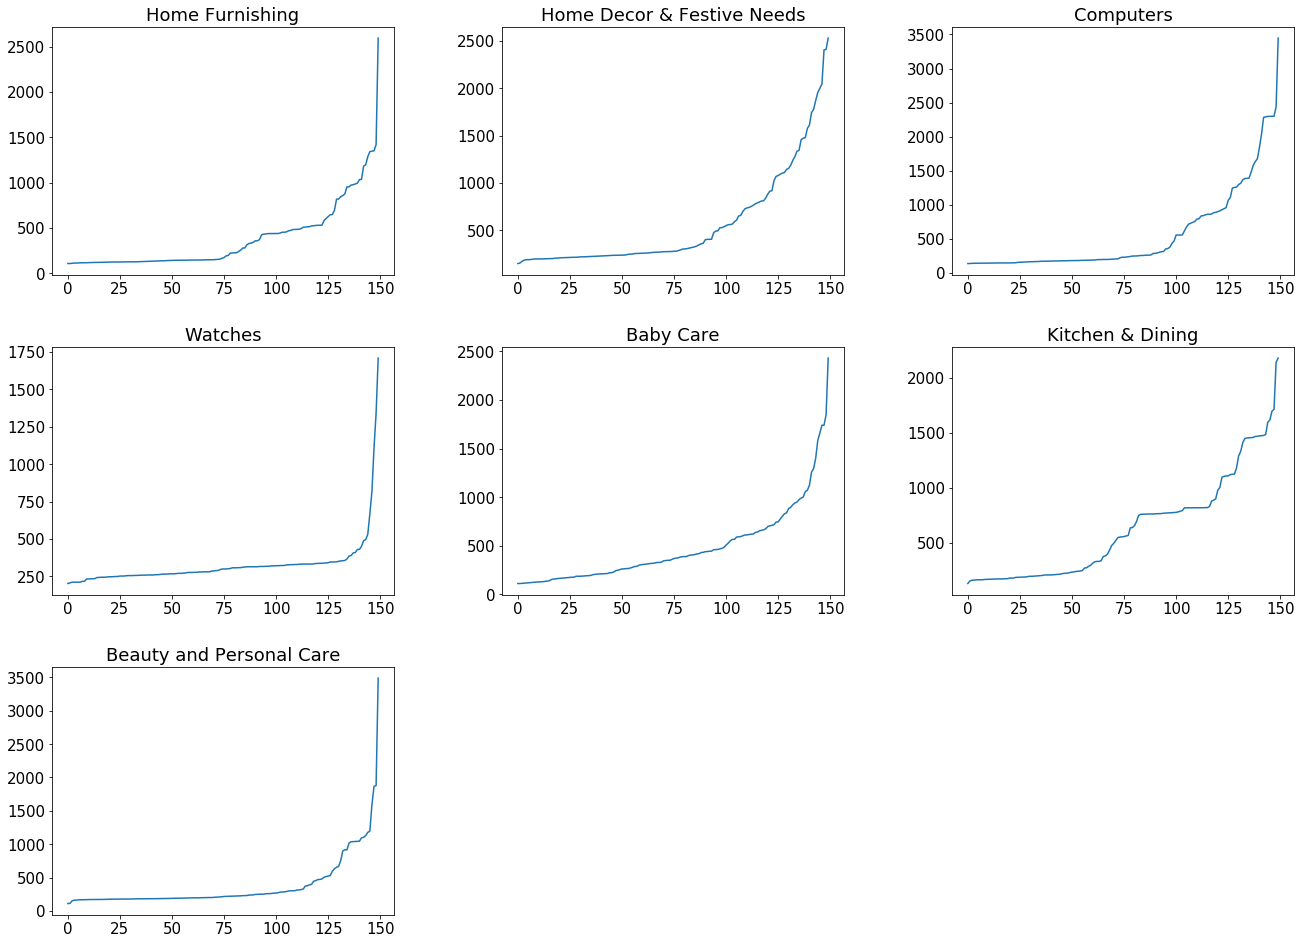

In [47]:
#   Nombre de caractères des descriptions selon la catégorie :

hf = flipkart[flipkart.category == 'Home Furnishing'].sort_values(by = 'l_descript', ascending=True)
hf.reset_index(drop = True, inplace = True)
hd = flipkart[flipkart.category == 'Home Decor & Festive Needs'].sort_values(by = 'l_descript', ascending=True)
hd.reset_index(drop = True, inplace = True)
co = flipkart[flipkart.category == 'Computers'].sort_values(by = 'l_descript', ascending=True)
co.reset_index(drop = True, inplace = True)
wa = flipkart[flipkart.category == 'Watches'].sort_values(by = 'l_descript', ascending=True)
wa.reset_index(drop = True, inplace = True)
bc = flipkart[flipkart.category == 'Baby Care'].sort_values(by = 'l_descript', ascending=True)
bc.reset_index(drop = True, inplace = True)
kd = flipkart[flipkart.category == 'Kitchen & Dining'].sort_values(by = 'l_descript', ascending=True)
kd.reset_index(drop = True, inplace = True)
bp = flipkart[flipkart.category == 'Beauty and Personal Care'].sort_values(by = 'l_descript', ascending=True)
bp.reset_index(drop = True, inplace = True)


fig = plt.figure(1)
fig = plt.figure(figsize = (20, 15))
plt.subplot(3,3,1)
plt.title('Home Furnishing')
plt.plot(hf.l_descript)

plt.subplot(3,3,2)
plt.title('Home Decor & Festive Needs')
plt.plot(hd.l_descript)

plt.subplot(3,3,3)
plt.title('Computers')
plt.plot(co.l_descript)

plt.subplot(3,3,4)
plt.title('Watches')
plt.plot(wa.l_descript)

plt.subplot(3,3,5)
plt.title('Baby Care')
plt.plot(bc.l_descript)

plt.subplot(3,3,6)
plt.title('Kitchen & Dining')
plt.plot(kd.l_descript)

plt.subplot(3,3,7)
plt.title('Beauty and Personal Care')
plt.plot(bp.l_descript)

plt.tight_layout(pad=5.0, w_pad=4.0, h_pad=2.0)   # marges

#fig.savefig("taille_descript")

In [48]:
# Contrôle données manquantes -> OK

flipkart.isna().sum()

product        0
category       0
image          0
description    0
l_descript     0
dtype: int64

In [49]:
# Distribution des catégories de produits

flipkart['category'].value_counts()

# Home Furnishing               : Ameublement
# Home Decor & Festive Needs    : Décor à la maison et besoins festifs
# Computers                     : ordinateurs
# Watches                       : Montres
# Baby Care                     : Soins bébé
# Kitchen & Dining              : Cuisine et salle à manger
# Beauty and Personal Care      : Beauté et soins personnels

Kitchen & Dining              150
Beauty and Personal Care      150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Home Furnishing               150
Computers                     150
Name: category, dtype: int64

In [50]:
from sklearn.preprocessing import LabelEncoder

X = flipkart['category']

transformer = LabelEncoder()
flipkart.insert(0, 'categ', transformer.fit_transform(X))   # les 2 en 1
flipkart.head(6)


,categ,product,category,image,description,l_descript
0,4,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,1420
1,0,Sathiyas Cotton Bath Towel,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,444
2,0,Eurospa Cotton Terry Face Towel Set,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,1258
3,4,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,858
4,4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,1197
5,6,Maserati Time R8851116001 Analog Watch - For ...,Watches,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Maserati Time R8851116001 Analog Watch - For ...,275


In [51]:
# Le dataframe 'flipkart_img' sera utilisé dans la section relative aux IMAGES.

flipkart_img = flipkart.copy()
flipkart_img = flipkart_img.drop(['description','l_descript'], 1)
flipkart_img.head(5)

,categ,product,category,image
0,4,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,0,Sathiyas Cotton Bath Towel,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,0,Eurospa Cotton Terry Face Towel Set,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,4,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
4,4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg


# Traitement des descriptions

In [52]:
x=10   # x sera l'indice du produit affiché aprés traitement

## Pré-Traitement

In [53]:
#   1. Suppression des liens hypertexte
#   2. Suppression des Tags
#   3. Suppression des emoticones
#   4. Suppression des chiffres

import emoji

def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def pre_traite(com):
    com = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|''(?:%[0-9a-fA-F][0-9a-fA-F]))+',"", com)
    com = re.sub("(@[A-Za-z0-9_]+)","", com)
    com = re.sub("(#[A-Za-z0-9_]+)","", com)
    com = give_emoji_free_text(com)
    
    res = ''.join(i for i in com if not i.isdigit())   # sup les chiffres
    return(res)

print("AVANT:\n", flipkart.iloc[x].description)
flipkart['description'] = flipkart['description'].apply(pre_traite)
print("\nAPRES:\n", flipkart.iloc[x].description)


AVANT:
 Calibro SW-125 Analog-Digital Watch  - For Men, Boys
                         Price: Rs. 699
				
			CALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well executed by this brand. Get one and see how brilliantly it leads other brands in style, finish and everything else that matters.
CALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well executed by this

## Tokenisation

In [54]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

def to_token(com):
    com = tokenizer.tokenize(com.lower())   # majuscule -> minuscule
    #com = tokenizer.tokenize(com)
    return(com)

print("AVANT:\n", flipkart.iloc[x].description)
flipkart['description'] = flipkart['description'].apply(to_token)
print("\nAPRES:\n", flipkart.iloc[x].description)

AVANT:
 Calibro SW- Analog-Digital Watch - For Men, Boys Price: Rs.  CALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well executed by this brand. Get one and see how brilliantly it leads other brands in style, finish and everything else that matters. CALIBRO presents MTG Black Dial Round Watch. This is a fashionable watch from MTG that adds to your style statement. This brand is known for its usage of quality material in making appealing watches. It understands the needs of youth so well that it is able to present wide range of watches to its customers. The variety in design, style and youthful approach is very well executed by this brand. Get one and see how brilliantly 

## Suppression des stopwords

In [32]:
from nltk.corpus import stopwords


nltk.download('stopwords')

stop_words = stopwords.words('english')

# On peut rajouter aux 'stop_words' la ponctuation
exclude = set(string.punctuation)
stop_words.extend(exclude)

def del_stopwords(com):
    com = [word for word in com if word not in stop_words and word.isalpha()]
    return(com)

print("AVANT:\n", flipkart.iloc[x].description)
flipkart['description'] = flipkart['description'].apply(del_stopwords)
print("\nAPRES:\n", flipkart.iloc[x].description)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
AVANT:
 ['calibro', 'sw', 'analog', 'digital', 'watch', 'for', 'men', 'boys', 'price', 'rs', 'calibro', 'presents', 'mtg', 'black', 'dial', 'round', 'watch', 'this', 'is', 'a', 'fashionable', 'watch', 'from', 'mtg', 'that', 'adds', 'to', 'your', 'style', 'statement', 'this', 'brand', 'is', 'known', 'for', 'its', 'usage', 'of', 'quality', 'material', 'in', 'making', 'appealing', 'watches', 'it', 'understands', 'the', 'needs', 'of', 'youth', 'so', 'well', 'that', 'it', 'is', 'able', 'to', 'present', 'wide', 'range', 'of', 'watches', 'to', 'its', 'customers', 'the', 'variety', 'in', 'design', 'style', 'and', 'youthful', 'approach', 'is', 'very', 'well', 'executed', 'by', 'this', 'brand', 'get', 'one', 'and', 'see', 'how', 'brilliantly', 'it', 'leads', 'other', 'brands', 'in', 'style', 'finish', 'and', 'everything', 'else', 'that', '

## Lemmatisation

In [33]:
import fr_core_news_md
import en_core_web_md

nlp = spacy.load('en_core_web_md')
delimiteur = ' '

def lemmatize(com):
    new_sentence = []
    doc = nlp(delimiteur.join(com))   # convertit une list en str
    for word in doc:
        new_sentence.append(word.lemma_)
    return(new_sentence)

print("AVANT:\n", flipkart.iloc[x].description)
flipkart['description'] = flipkart['description'].apply(lemmatize)
print("\nAPRES:\n", flipkart.iloc[x].description)

AVANT:
 ['calibro', 'sw', 'analog', 'digital', 'watch', 'men', 'boys', 'price', 'rs', 'calibro', 'presents', 'mtg', 'black', 'dial', 'round', 'watch', 'fashionable', 'watch', 'mtg', 'adds', 'style', 'statement', 'brand', 'known', 'usage', 'quality', 'material', 'making', 'appealing', 'watches', 'understands', 'needs', 'youth', 'well', 'able', 'present', 'wide', 'range', 'watches', 'customers', 'variety', 'design', 'style', 'youthful', 'approach', 'well', 'executed', 'brand', 'get', 'one', 'see', 'brilliantly', 'leads', 'brands', 'style', 'finish', 'everything', 'else', 'matters', 'calibro', 'presents', 'mtg', 'black', 'dial', 'round', 'watch', 'fashionable', 'watch', 'mtg', 'adds', 'style', 'statement', 'brand', 'known', 'usage', 'quality', 'material', 'making', 'appealing', 'watches', 'understands', 'needs', 'youth', 'well', 'able', 'present', 'wide', 'range', 'watches', 'customers', 'variety', 'design', 'style', 'youthful', 'approach', 'well', 'executed', 'brand', 'get', 'one', 'see'

## Suppression des entités nommées (Named-Entity Recognition = NER)

In [34]:
# SpaCy compte 17 types d’entités reconnues :    PERSON, NORP, FACILITY, ORG, GPE, LOC, PRODUCT, EVENT, WORK_OF_ART, 
#                                                LANGUAGE, DATE, TIME, PERCENT, MONEY, QUANTITY, ORDINAL CARDINAL, TOPIC

nlp_en = spacy.load('en_core_web_md')

delimiteur = ' '
org     = []
person  = []
loc     = []
product = []

norp    = []
facility= []

def to_ner(comment):
    com = delimiteur.join(comment)
    doc = nlp_en(com)

    for ent in doc.ents:
        if ent.label_ == "NORP":     # : natianalité, groupes religieux
            norp.append(ent.text)
        if ent.label_ == "ORG":
            org.append(ent.text)
        elif ent.label_ == "PRODUCT":
            product.append(ent.text)
        elif ent.label_ == "PERSON":
            person.append(ent.text)
        elif ent.label_ == "LOC":
            loc.append(ent.text)


flipkart['description'].apply(to_ner)

print("Organisations :", org)
print("\nPersonnes :", person)
print("\nLieux :", loc)
print("\nProduits :", product)
print("\nNorp :", norp)


# On retire du corpus l'ensemble des ORG, PER, LOC, PRODUCT, NORP.
ner_words = org + person + loc + product + norp

def del_nerwords(com):
    com = [word for word in com if word not in ner_words]
    return(com)

print("AVANT:\n", flipkart.iloc[x].description)
flipkart['description'] = flipkart['description'].apply(del_nerwords)
print("\nAPRES:\n", flipkart.iloc[x].description)

print("\n\nAu final", len(ner_words),"mots ont été retiré du corpus.")


Organisations : ['gsm', 'gsm', 'terry design shuvam', 'eurospa gsm', 'santosh royal fashion cotton print king', 'santosh royal fashion cotton print king', 'santosh royal fashion machine washable', 'goldbedi', 'jaipur print cotton floral king', 'jaipur', 'maserati', 'maserati time r analog watch', 'alrams great', 'calibro sw', 'mtg black dial round', 'mtg', 'mtg black', 'mtg', 'lcs analog watch', 'lcs', 'titan', 'sl', 'rs', 'srushti art jewelry digital', 'srushti art jewelry digital', 'digital watch', 'digital watch', 'fbc', 'skmei', 'skmei', 'rs india', 'digital', 'skmei dg red sports digital watch', 'skmei dg red sports digital watch', 'digital', 'fastrack pl', 'fastrack pl', 'com stainless steel', 'quartz analogue movement great', 'qibla compass', 'qibla compass', 'com', 'disney analog watch', 'disney analog watch', 'disney', 'disney', 'dw', 'vizion purple sports series', 'rs', 'elantra', 'elantra', 'lenco bdblue', 'analog watch', 'lenco bdblue', 'analog watch man', 'santosh royal fa



Personnes : ['camerii wm', 'wm', 'alfajr', 'alfajr', 'gregorian calnedars qur', 'cau ba', 'cau ba', 'cau ba', 'lois caron', 'lois caron lcs', 'srushti girlswatch', 'jack klein', 'jack klein', 'blackled', 'franck bella fbc', 'franck bella fbc', 'ridas apple', 'franck bella fba', 'franck bella fba', 'fba', 'alfajr wq', 'santosh royal', 'ducjug ducgl', 'jug glass', 'ducjug ducgl', 'copperware', 'ducjug ducgl', 'ducjug ducgl', 'akup', 'akup', 'mug akup', 'akup', 'roq', 'roq', 'casserole cookart', 'cookart', 'rythmx', 'rythmx', 'giftbags jutebags', 'giftbag jutebags', 'katori', 'giorgio armani', 'xx cms', 'te type fengshui', 'chinmay', 'chinmay kids', 'gb ram', 'lan gb', 'aapno rajasthan', 'aapno rajasthan', 'vaishnava', 'vaishnava', 'gurunanak', 'radha krishna', 'dohar', 'lollipop lane', 'recrafto buddha', 'recrafto brass buddha', 'mpad', 'mpad', 'specification toffyhouse', 'specification sos', 'mnts', 'arsalan inch glass', 'arsalan inch glass', 'prithish', 'rockmantra fogg', 'rockmantra

Norp : ['machinewash', 'myesquire', 'myesquire', 'luman', 'polish', 'polish', 'polish', 'polish', 'polish', 'polish', 'polish', 'polish', 'polish', 'polish', 'shopmania', 'gayatri', 'stor', 'vsswh', 'gujarat secondary', 'ganesha', 'ganesha', 'swiss', 'swiss', 'puja', 'cmr', 'ganesha', 'rajasthan', 'indian', 'rajasthan', 'indian', 'subfreeze', 'prithish', 'prithish', 'prithish', 'chinese', 'chinese', 'indian', 'indian', 'chinese', 'polish', 'chinese', 'polish', 'chinese', 'chinese', 'rajasthan', 'indian', 'rajasthan', 'indian', 'beautiful indian rajasthani', 'beautiful indian rajasthani', 'rajasthani', 'rajasthani', 'metallino', 'indian', 'indian', 'indian', 'indian', 'rajasthani', 'rajasthani', 'italian', 'italian', 'adino', 'pooja', 'pooja', 'ganesha', 'pooja', 'pooja', 'pooja', 'ganesha', 'pooja', 'pooja', 'puja', 'hindu', 'jains', 'buddhists', 'ganesha', 'ganesha', 'pooja', 'pooja', 'ganesha', 'ganesha', 'nihar', 'floralina', 'kamasutra', 'french', 'zingalalaa', 'polish', 'polish', 

# Classification des produits via leur description

## Bag of Words

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

def to_text(descript):
    return(delimiteur.join(descript))

df2 = flipkart.copy()
df2['description'] = df2['description'].apply(to_text)

cv = CountVectorizer(min_df=5)      # 'min_df=5' => Un mot est ajouté au vocabulaire s’il apparait au moins 5 fois.
texts = df2['description']
cv.fit(texts)
print ("Vocabulaire contenant",  len (cv.vocabulary_),"mots distincts.\n")
print ("Ordre d’encodage des mots:\n",  cv.vocabulary_)
      
bow = cv.transform(texts)           # bow est le sac de mots
sdm = bow.toarray()
print(sdm.shape,"\n")

Vocabulaire contenant 889 mots distincts.

Ordre d’encodage des mots:
 {'key': 428, 'feature': 296, 'elegance': 261, 'polyester': 613, 'multicolor': 525, 'abstract': 1, 'eyelet': 285, 'door': 240, 'curtain': 191, 'floral': 311, 'cm': 139, 'height': 384, 'pack': 567, 'price': 625, 'enhance': 266, 'look': 476, 'interior': 420, 'make': 486, 'high': 386, 'quality': 641, 'fabric': 286, 'style': 777, 'metal': 502, 'ring': 677, 'room': 682, 'love': 480, 'anti': 27, 'elegant': 262, 'give': 346, 'home': 390, 'bright': 90, 'appeal': 30, 'design': 218, 'sure': 785, 'contemporary': 170, 'first': 307, 'morning': 518, 'want': 844, 'good': 355, 'whole': 864, 'world': 882, 'create': 187, 'special': 751, 'moment': 515, 'beauty': 64, 'print': 626, 'bring': 91, 'light': 460, 'get': 341, 'right': 676, 'specification': 753, 'general': 336, 'brand': 87, 'type': 821, 'name': 532, 'set': 707, 'pron': 630, 'would': 883, 'color': 147, 'dimension': 229, 'length': 455, 'box': 84, 'number': 545, 'content': 171, 's

(1050, 889) 



### Clustering K-means

In [36]:
from sklearn.cluster import KMeans

X = sdm

km = KMeans(n_clusters=7, init='k-means++', n_init=20)
km.fit(X)
clusters_BW = km.labels_    # Récupération des clusters attribués à chaque produit

set(clusters_BW)            # le 1er cluster est le '0'

{0, 1, 2, 3, 4, 5, 6}

In [37]:
# Affichage du nombre de Produits pour chaque cluster

products = flipkart['product']

# Dataframe associant le produit au cluster :
productCluster = pd.DataFrame({"Produit": products, "cluster": clusters_BW})
# print(productCluster.head(3), "\n")

# Dataframe du nombre de clients par cluster :
productCluster['product'] = 1
cumul_km = productCluster.groupby(['cluster']).sum().reset_index()
cumul_km.columns = ['cluster', 'nb_produits']
print(cumul_km)

flipkart['cluster'] = clusters_BW    # Association du cluster à chaque produit
flipkart.head(3)

   cluster  nb_produits
0        0            5
1        1          284
2        2           11
3        3          694
4        4           42
5        5            7
6        6            7


,categ,product,category,image,description,cluster
0,4,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,0.jpg,"[key, feature, elegance, polyester, multicolor...",1
1,0,Sathiyas Cotton Bath Towel,Baby Care,1.jpg,"[specifications, cotton, bath, towel, bath, to...",1
2,0,Eurospa Cotton Terry Face Towel Set,Baby Care,2.jpg,"[key, feature, eurospa, cotton, terry, face, t...",1


In [38]:
flipkart

,categ,product,category,image,description,cluster
0,4,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,0.jpg,"[key, feature, elegance, polyester, multicolor...",1
1,0,Sathiyas Cotton Bath Towel,Baby Care,1.jpg,"[specifications, cotton, bath, towel, bath, to...",1
2,0,Eurospa Cotton Terry Face Towel Set,Baby Care,2.jpg,"[key, feature, eurospa, cotton, terry, face, t...",1
3,4,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,3.jpg,"[key, feature, santosh, royal, fashion, cotton...",5
4,4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,4.jpg,"[key, feature, print, cotton, floral, king, si...",5
5,6,Maserati Time R8851116001 Analog Watch - For ...,Watches,5.jpg,"[time, r, analog, watch, boy, buy, time, r, an...",3
6,6,"Camerii WM64 Elegance Analog Watch - For Men,...",Watches,6.jpg,"[camerii, elegance, analog, watch, man, boy, b...",3
7,6,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,Watches,7.jpg,"[star, uft, tsw, bk, br, analog, watch, boy, p...",3
8,6,"Alfajr WY16B Youth Digital Watch - For Men, Boys",Watches,8.jpg,"[wyb, youth, watch, man, boy, buy, wyb, youth,...",3
9,6,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,Watches,9.jpg,"[tag, heuer, cau, ba, formula, analog, watch, ...",3


### Représentation Tsne

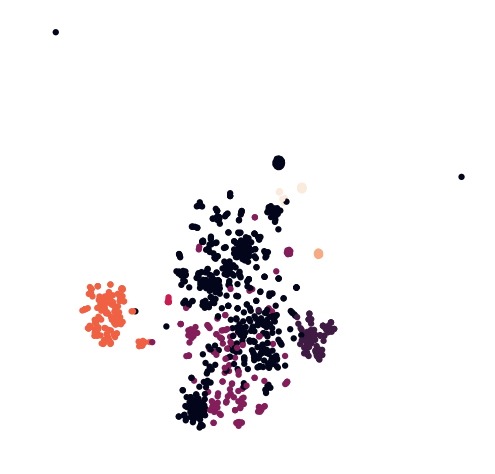

In [204]:
# Projection des produits avec t-SNE (t-Stochastic Neighbour Embedding)

from sklearn.manifold import TSNE

def fashion_scatter(x):
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=clusters_BW)
    ax.axis('off')
    ax.axis('tight')
    plt.show()

tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(X)
fashion_scatter(X_2d)

### Matching Clustering Kmeans - Classification humaine

In [39]:
from sklearn import metrics

rand_score = metrics.adjusted_rand_score(flipkart['category'], flipkart['cluster'])
        
print("Rand Score ajusté =\n", rand_score)


Rand Score ajusté =
 0.042780496146592996


### Matrice de confusion

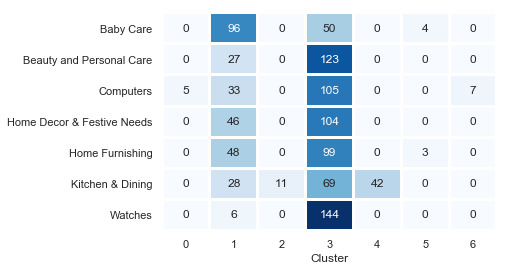

In [40]:
# Evaluation de la qualité d'un modèle de classification

from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set()
cm = confusion_matrix(flipkart['categ'], flipkart['cluster'])

df_cm = pd.DataFrame(cm, columns=np.unique(flipkart['categ']), index = np.unique(flipkart['category']))
df_cm.columns.name = 'Cluster'

ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=2, cbar=False)

## TF_IDF (termes les plus représentatifs d'une description)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer


delimiteur = ' '
texte = []

def tfidf(descript):
    descripts = delimiteur.join(descript)   # convertit une list en str
    texte.append(descripts)
    
flipkart['description'].apply(tfidf)

#  max_df = 0.99 =>  ignore les mots qui apparaissent dans plus  de 99% des descriptions.
#  min_df = 0.06 =>  ignore les mots qui apparaissent dans moins de 6%  des descriptions.

tfidf = TfidfVectorizer(max_df=0.99, min_df = 0.06)
values = tfidf.fit_transform(texte)
print(tfidf.get_feature_names())
print("Nombre de features :", len(tfidf.get_feature_names()))


['additional', 'also', 'analog', 'baby', 'black', 'body', 'box', 'boy', 'brand', 'buy', 'care', 'cash', 'ceramic', 'cm', 'color', 'content', 'cotton', 'cover', 'day', 'delivery', 'design', 'detail', 'dial', 'dimension', 'discount', 'fabric', 'feature', 'free', 'general', 'genuine', 'gift', 'girl', 'give', 'good', 'great', 'guarantee', 'height', 'high', 'home', 'ideal', 'inch', 'india', 'key', 'length', 'look', 'love', 'make', 'man', 'material', 'ml', 'mug', 'multicolor', 'name', 'number', 'one', 'online', 'pack', 'package', 'pattern', 'perfect', 'price', 'print', 'product', 'quality', 'replacement', 'resistant', 'round', 'sale', 'set', 'shipping', 'showpiece', 'size', 'specification', 'strap', 'style', 'type', 'use', 'wash', 'watch', 'water', 'weight', 'width', 'woman', 'would', 'yes']
Nombre de features : 85


In [50]:
feature_names = tfidf.get_feature_names()
corpus_index = [n for n in list(tfidf.vocabulary_.keys())]
df = pd.DataFrame(values.todense(), columns=feature_names)   # todense():  convert sparse matrix to numpy array
print("Nombre de MOTS(features) retenus :", len(feature_names),"\n")

adf = df.rename_axis('ID').values
print("\nTaille de adf:", len(adf))

df.head(6)

Nombre de MOTS(features) retenus : 85 


Taille de adf: 1050


,additional,also,analog,baby,black,body,box,boy,brand,buy,care,cash,ceramic,cm,color,content,cotton,cover,day,delivery,design,detail,dial,dimension,discount,fabric,feature,free,general,genuine,gift,girl,give,good,great,guarantee,height,high,home,ideal,inch,india,key,length,look,love,make,man,material,ml,mug,multicolor,name,number,one,online,pack,package,pattern,perfect,price,print,product,quality,replacement,resistant,round,sale,set,shipping,showpiece,size,specification,strap,style,type,use,wash,watch,water,weight,width,woman,would,yes
0,0.0,0.0,0.000000,0.0,0.0,0.125344,0.082055,0.000000,0.087738,0.000000,0.000000,0.000000,0.0,0.274798,0.084705,0.100271,0.000000,0.000000,0.000000,0.000000,0.280844,0.0,0.0,0.100271,0.000000,0.107984,0.162783,0.000000,0.077897,0.000000,0.000000,0.000000,0.246025,0.085143,0.00000,0.000000,0.234457,0.123012,0.241663,0.000000,0.000000,0.000000,0.089363,0.124865,0.124865,0.12583,0.184637,0.000000,0.088703,0.0,0.0,0.470442,0.113290,0.086799,0.0,0.000000,0.26369,0.173598,0.0,0.0,0.056112,0.109764,0.000000,0.111004,0.000000,0.0,0.0,0.173290,0.096572,0.000000,0.0,0.000000,0.078015,0.0,0.118783,0.083987,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.123466,0.000000
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.120724,0.000000,0.129084,0.000000,0.000000,0.000000,0.0,0.000000,0.124622,0.147524,0.462054,0.000000,0.000000,0.000000,0.275462,0.0,0.0,0.147524,0.000000,0.000000,0.119748,0.000000,0.114606,0.000000,0.000000,0.169755,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.148205,0.348356,0.000000,0.000000,0.183708,0.000000,0.00000,0.000000,0.170825,0.130505,0.0,0.0,0.000000,0.166679,0.127703,0.0,0.000000,0.00000,0.255406,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.254953,0.000000,0.000000,0.0,0.160602,0.000000,0.0,0.000000,0.123566,0.000000,0.000000,0.00000,0.000000,0.000000,0.166679,0.177774,0.181650,0.181650
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.060467,0.087827,0.129309,0.000000,0.167470,0.000000,0.0,0.000000,0.124839,0.073890,0.462859,0.000000,0.000000,0.000000,0.137971,0.0,0.0,0.073890,0.000000,0.000000,0.119956,0.000000,0.057403,0.000000,0.000000,0.085025,0.090649,0.000000,0.00000,0.000000,0.086387,0.000000,0.000000,0.074231,0.261722,0.000000,0.065852,0.092014,0.000000,0.00000,0.000000,0.085561,0.065366,0.0,0.0,0.000000,0.083485,0.063963,0.0,0.000000,0.00000,0.127925,0.0,0.0,0.041349,0.080886,0.108906,0.081800,0.000000,0.0,0.0,0.127698,0.498154,0.000000,0.0,0.321764,0.057490,0.0,0.000000,0.061891,0.081568,0.267125,0.00000,0.083237,0.087241,0.083485,0.089042,0.090983,0.000000
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.056703,0.000000,0.060629,0.000000,0.078521,0.000000,0.0,0.506380,0.058533,0.069290,0.289360,0.423478,0.000000,0.000000,0.064690,0.0,0.0,0.069290,0.000000,0.074620,0.056244,0.000000,0.053829,0.000000,0.078287,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.327235,0.000000,0.061752,0.258854,0.000000,0.00000,0.000000,0.000000,0.061296,0.0,0.0,0.162544,0.078287,0.059980,0.0,0.000000,0.00000,0.119961,0.0,0.0,0.000000,0.227549,0.000000,0.000000,0.000000,0.0,0.0,0.119748,0.000000,0.000000,0.0,0.226298,0.053911,0.0,0.000000,0.058037,0.000000,0.083498,0.00000,0.000000,0.000000,0.234860,0.000000,0.085318,0.085318
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.049781,0.000000,0.053228,0.000000,0.068936,0.000000,0.0,0.444567,0.051388,0.060832,0.381058,0.371785,0.000000,0.000000,0.000000,0.0,0.0,0.060832,0.000000,0.065511,0.049378,0.000000,0.047258,0.000000,0.000000,0.000000,0.223886,0.051654,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.287290,0.000000,0.054214,0.227257,0.075752,0.00000,0.056007,0.000000,0.053814,0.0,0.0,0.000000,0.068730,0.052659,0.0,0.000000,0.00000,0.105317,0.0,0.0,0.034042,0.332954,0.059773,0.067343,0.000000,0.0,0.0,0.105130,0.000000,0.000000,0.0,0.264899,0.047330,0.0,0.000000,0.050953,0.067153,0.000000,0.00000,0.000000,0.071823,0.206191,0.000000,0.074904,0.074904
5,0.0,0.0,0.460781,0.0,0.0,0.000000,0.00000

### Clustering K-means

In [45]:
from sklearn.cluster import KMeans

X = adf

km = KMeans(n_clusters=7, init='k-means++', n_init=20)
km.fit(X)
clusters_TF = km.labels_    # Récupération des clusters attribués à chaque individu

set(clusters_TF)            # le 1er cluster est le '0'

{0, 1, 2, 3, 4, 5, 6}

In [46]:
# Affichage du nombre de Clients pour chaque cluster

products = flipkart['product']

# Dataframe associant le produit au cluster :
productCluster = pd.DataFrame({"Produit": products, "cluster": clusters_TF})

# Dataframe du nombre de clients par cluster :
productCluster['product'] = 1
cumul_km = productCluster.groupby(['cluster']).sum().reset_index()
cumul_km.columns = ['cluster', 'nb_produits']
print(cumul_km)

flipkart['cluster'] = clusters_TF    # Association du cluster à chaque produit
flipkart.head(3)

   cluster  nb_produits
0        0           85
1        1           95
2        2          147
3        3           85
4        4          251
5        5          312
6        6           75


,categ,product,category,image,description,cluster
0,4,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,0.jpg,"[key, feature, elegance, polyester, multicolor...",5
1,0,Sathiyas Cotton Bath Towel,Baby Care,1.jpg,"[specifications, cotton, bath, towel, bath, to...",5
2,0,Eurospa Cotton Terry Face Towel Set,Baby Care,2.jpg,"[key, feature, eurospa, cotton, terry, face, t...",5


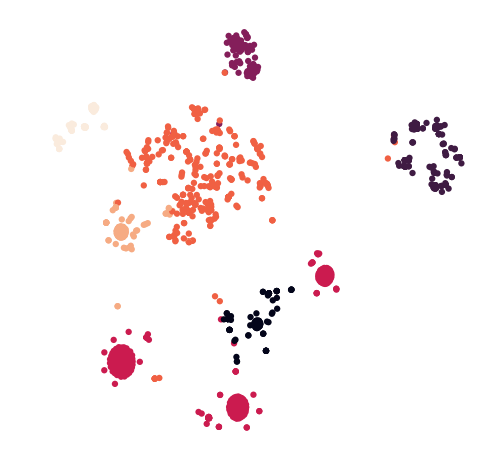

In [211]:
from sklearn.manifold import TSNE

def fashion_scatter(x):
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=clusters_TF)
    ax.axis('off')
    ax.axis('tight')
    plt.show()

tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(X)
fashion_scatter(X_2d)

### Matching  Clustering Kmeans - Classification humaine

In [47]:
from sklearn import metrics

rand_score = metrics.adjusted_rand_score(flipkart['category'], flipkart['cluster'])
        
print("Rand Score ajusté =\n", rand_score)


Rand Score ajusté =
 0.3492680185425397


In [ ]:
# (max_df=0.99, min_df = 0.01)   Rand Score ajusté =  0.2634
# (max_df=0.99, min_df = 0.02)   Rand Score ajusté =  0.2673
# (max_df=0.99, min_df = 0.03)   Rand Score ajusté =  0.2534
# (max_df=0.99, min_df = 0.04)   Rand Score ajusté =  0.3201
# (max_df=0.99, min_df = 0.05)   Rand Score ajusté =  0.3254
# (max_df=0.99, min_df = 0.06)   Rand Score ajusté =  0.3492
# (max_df=0.99, min_df = 0.07)   Rand Score ajusté =  0.3041
# (max_df=0.99, min_df = 0.08)   Rand Score ajusté =  0.3257
# (max_df=0.99, min_df = 0.09)   Rand Score ajusté =  0.3284
# (max_df=0.99, min_df = 0.1)    Rand Score ajusté =  0.3062
# (max_df=0.99, min_df = 0.15)   Rand Score ajusté =  0.2469
# (max_df=0.99, min_df = 0.20)   Rand Score ajusté =  0.2053

### Matrice de confusion

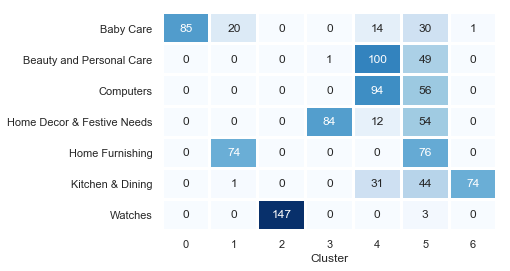

In [48]:
# Evaluation de la qualité d'un modèle de classification

from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set()
cm = confusion_matrix(flipkart['categ'], flipkart['cluster'])

df_cm = pd.DataFrame(cm, columns=np.unique(flipkart['categ']), index = np.unique(flipkart['category']))
df_cm.columns.name = 'Cluster'

ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=2, cbar=False)

## LDA   (Latent Dirichlet Allocation)

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

def to_text(descript):
    return(delimiteur.join(descript))

df2 = flipkart.copy()
df2['description'] = df2['description'].apply(to_text)

cv = CountVectorizer(min_df=5)      # Un mot est ajouté au vocabulaire s’il apparait au moins 5 fois.
texts = df2['description']
cv.fit(texts)
print ("Vocabulaire contenant",  len (cv.vocabulary_),"mots distincts.\n")
   
bow = cv.transform(texts)   # bow est le sac de mots

Vocabulaire contenant 889 mots distincts.



In [52]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 7

# Crée le modèle LDA en considérant qu'il y a 7 sujets = 7 topics = 7 catégories.
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

lda.fit(bow)   # Fit des données

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=7, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [68]:
# Pour (min_df=3), on a 1050 mots et Rand Score ajusté = 0.0925
# Pour (min_df=4), on a 1050 mots et Rand Score ajusté = 0.0952
# Pour (min_df=5), on a  889 mots et Rand Score ajusté = 0.1027  *
# Pour (min_df=6), on a  889 mots et Rand Score ajusté = 0.0773

In [69]:
# Affichage des sujets à partir des mots qui ont le plus de poids dans ces sujets :
#
# feature_names :  les mots qui seront associés au comptage
# no_top_words  :  les 20 mots les plus représentatifs de la catégorie détectée

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTOPIC {}:".format(topic_idx))
        #print("{}:".format(topic))
        print(" ".join([feature_names()[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, cv.get_feature_names, 20)

#  Affiche pour chacun des 7 topics, les 20 mots les + forts dans l'ordre


TOPIC 0:
mugs bowl perfect bring coffee design around special break attractive distinctive express well catchy cute message cheer mean ink selection

TOPIC 1:
cm baby cotton pack color general type design fabric box feature specification number girl package sale detail print brand polyester

TOPIC 2:
product eye beauty lip price quality cream face craft oxyglow make range bring massage beautifully art vitamin get colour canvas

TOPIC 3:
free delivery product buy cash genuine shipping day replacement guarantee online watch analog price good man india great discount showpiece

TOPIC 4:
skin warranty shape print pad inch mouse set multicolor size quality product type feature adapter power brand color high specification

TOPIC 5:
glass bottle water pizza steel price design cutter pack nutcase soap copper ml wrap stainless use durable frame body come

TOPIC 6:
mug sticker wall ceramic make cm home product gift material price design coffee perfect feature one apply size use give


In [70]:
# Trouver les topics dominants avec LDA model
# et assigner les descriptions à leurs topics respectifs avec LDA

topic_results = lda.transform(bow)

topics = topic_results.argmax(axis=1)   # les indices du meilleur résultat de tous les produits
flipkart['topic'] = topics

flipkart.head(5)

,categ,product,category,image,description,cluster,topic
0,4,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,0.jpg,"[key, feature, elegance, polyester, multicolor...",6,1
1,0,Sathiyas Cotton Bath Towel,Baby Care,1.jpg,"[specifications, cotton, bath, towel, bath, to...",6,1
2,0,Eurospa Cotton Terry Face Towel Set,Baby Care,2.jpg,"[key, feature, eurospa, cotton, terry, face, t...",6,1
3,4,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,3.jpg,"[key, feature, santosh, royal, fashion, cotton...",6,1
4,4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,4.jpg,"[key, feature, print, cotton, floral, king, si...",6,1


In [73]:
# Affichage du nombre de Produits pour chaque topic

products = flipkart['product']
topics   = flipkart['topic']

# Dataframe associant le produit au cluster :
productCluster = pd.DataFrame({"Produit": products, "topic": topics})   # produit - topic

# Dataframe du nombre de produits par topic :
productCluster['product'] = 1
cumul_km = productCluster.groupby(['topic']).sum().reset_index()
cumul_km.columns = ['topic', 'nb_produits']
print(cumul_km)


   topic  nb_produits
0      0           12
1      1          238
2      2           26
3      3          561
4      4           80
5      5           34
6      6           99


La représentation t-SNE du sac de mots a déjà été faite plus haut.
Avec LDA on utilise le sac de mots d'une autre manière, et la matrice résultante n'est pas affichable via t-SNE.

### Matching LDA - Classification humaine

In [74]:
from sklearn import metrics

rand_score = metrics.adjusted_rand_score(flipkart['category'], flipkart['topic'])
        
print("Rand Score ajusté =\n", rand_score)


Rand Score ajusté =
 0.09951043835748644


### Matrice de confusion

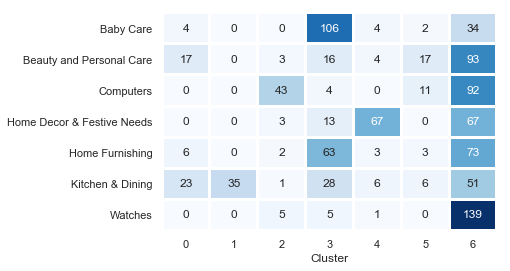

In [85]:
# Evaluation de la qualité d'un modèle de classification

from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set()
cm = confusion_matrix(flipkart['categ'], flipkart['topic'])

df_cm = pd.DataFrame(cm, columns=np.unique(flipkart['categ']), index = np.unique(flipkart['category']))
df_cm.columns.name = 'Cluster'

ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=2, cbar=False)

# Classification des produits via leur image

In [28]:
# Renommage des images dans le répertoire "./images" et dans le dataframe
#
#   ex: la 1ère image du dataframe 'flipkart_img' ne s'appelle plus "55b85ea15a1536d46b7190ad6fff8ce7.jpg" mais "0.jpg"

import os


path_img = "./images"

for i in flipkart_img.index:
    
    # dans le REPERTOIRE
    old_file = os.path.join(path_img, flipkart_img["image"][i])
    new_file = os.path.join(path_img, str(i)+".jpg")
    os.rename(old_file, new_file)
    
    # dans le DATAFRAME
    flipkart_img.at[i, 'image'] = str(i)+".jpg"

flipkart_img.head(3)

,categ,product,category,image
0,4,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,0.jpg
1,0,Sathiyas Cotton Bath Towel,Baby Care,1.jpg


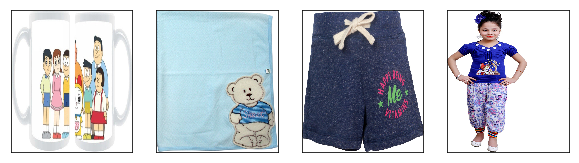

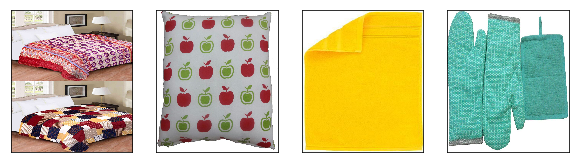

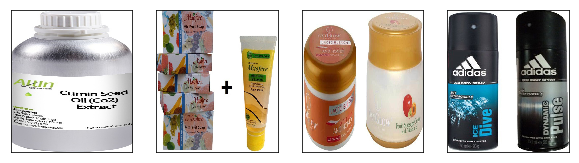

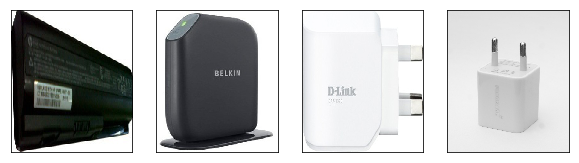

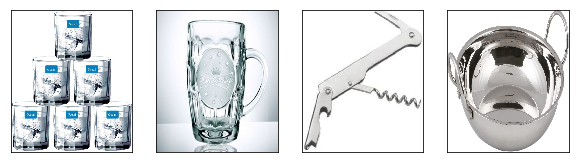

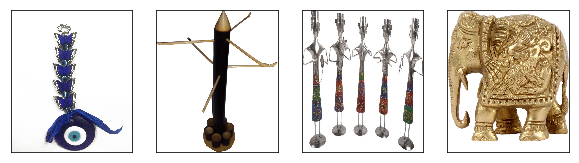

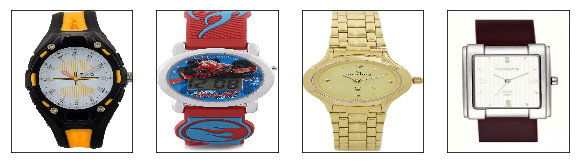

In [30]:
# --- Affichage aléatoires de 7*4 images ---

from PIL import Image
import random

categories = ["Baby Care", "Home Furnishing", "Beauty and Personal Care", "Computers", "Kitchen & Dining",
              "Home Decor & Festive Needs","Watches"]
path_img = "./images/"

f = list(np.arange(0,1050))
c = 4
r = random.sample(f, c)   # Dans 'f', on prend 'c' images
nrows = 1
ncols = 4

for categ in categories:
    X = flipkart_img[flipkart_img['category'] == categ]
    f = list(X.index)
    r = random.sample(f, c)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*10, ncols*3))

    for i in range(c):
    
        img_name = path_img+flipkart_img["image"][r[i]]
        img = Image.open(img_name)
        plt.subplot(4, 4, i+1)
        plt.imshow(img, aspect='auto')
        plt.xticks([])
        plt.yticks([])
    fig.savefig("subplot2_"+categ)
    plt.show()


## SIFT

### Conversion des images en niveau de gris

In [32]:
from PIL import Image

path_img = "./images/"

for i in flipkart_img.index:
    
    img_name = os.path.join(path_img, flipkart_img["image"][i])
    print("Image : ", img_name)
    img = Image.open(img_name)    # charger l'image
    img2 = img.convert('L')       # convertit en niveau de gris
    img2.save(img_name)


Image :  ./images/0.jpg
Image :  ./images/1.jpg
Image :  ./images/2.jpg
Image :  ./images/3.jpg
Image :  ./images/4.jpg
Image :  ./images/5.jpg
Image :  ./images/6.jpg
Image :  ./images/7.jpg
Image :  ./images/8.jpg
Image :  ./images/9.jpg
Image :  ./images/10.jpg
Image :  ./images/11.jpg
Image :  ./images/12.jpg
Image :  ./images/13.jpg
Image :  ./images/14.jpg
Image :  ./images/15.jpg
Image :  ./images/16.jpg
Image :  ./images/17.jpg
Image :  ./images/18.jpg
Image :  ./images/19.jpg
Image :  ./images/20.jpg
Image :  ./images/21.jpg
Image :  ./images/22.jpg
Image :  ./images/23.jpg
Image :  ./images/24.jpg
Image :  ./images/25.jpg
Image :  ./images/26.jpg
Image :  ./images/27.jpg
Image :  ./images/28.jpg
Image :  ./images/29.jpg
Image :  ./images/30.jpg
Image :  ./images/31.jpg
Image :  ./images/32.jpg
Image :  ./images/33.jpg
Image :  ./images/34.jpg
Image :  ./images/35.jpg
Image :  ./images/36.jpg
Image :  ./images/37.jpg
Image :  ./images/38.jpg
Image :  ./images/39.jpg
Image :  .

Image :  ./images/319.jpg
Image :  ./images/320.jpg
Image :  ./images/321.jpg
Image :  ./images/322.jpg
Image :  ./images/323.jpg
Image :  ./images/324.jpg
Image :  ./images/325.jpg
Image :  ./images/326.jpg
Image :  ./images/327.jpg
Image :  ./images/328.jpg
Image :  ./images/329.jpg
Image :  ./images/330.jpg
Image :  ./images/331.jpg
Image :  ./images/332.jpg
Image :  ./images/333.jpg
Image :  ./images/334.jpg
Image :  ./images/335.jpg
Image :  ./images/336.jpg
Image :  ./images/337.jpg
Image :  ./images/338.jpg
Image :  ./images/339.jpg
Image :  ./images/340.jpg
Image :  ./images/341.jpg
Image :  ./images/342.jpg
Image :  ./images/343.jpg
Image :  ./images/344.jpg
Image :  ./images/345.jpg
Image :  ./images/346.jpg
Image :  ./images/347.jpg
Image :  ./images/348.jpg
Image :  ./images/349.jpg
Image :  ./images/350.jpg
Image :  ./images/351.jpg
Image :  ./images/352.jpg
Image :  ./images/353.jpg
Image :  ./images/354.jpg
Image :  ./images/355.jpg
Image :  ./images/356.jpg
Image :  ./i

Image :  ./images/634.jpg
Image :  ./images/635.jpg
Image :  ./images/636.jpg
Image :  ./images/637.jpg
Image :  ./images/638.jpg
Image :  ./images/639.jpg
Image :  ./images/640.jpg
Image :  ./images/641.jpg
Image :  ./images/642.jpg
Image :  ./images/643.jpg
Image :  ./images/644.jpg
Image :  ./images/645.jpg
Image :  ./images/646.jpg
Image :  ./images/647.jpg
Image :  ./images/648.jpg
Image :  ./images/649.jpg
Image :  ./images/650.jpg
Image :  ./images/651.jpg
Image :  ./images/652.jpg
Image :  ./images/653.jpg
Image :  ./images/654.jpg
Image :  ./images/655.jpg
Image :  ./images/656.jpg
Image :  ./images/657.jpg
Image :  ./images/658.jpg
Image :  ./images/659.jpg
Image :  ./images/660.jpg
Image :  ./images/661.jpg
Image :  ./images/662.jpg
Image :  ./images/663.jpg
Image :  ./images/664.jpg
Image :  ./images/665.jpg
Image :  ./images/666.jpg
Image :  ./images/667.jpg
Image :  ./images/668.jpg
Image :  ./images/669.jpg
Image :  ./images/670.jpg
Image :  ./images/671.jpg
Image :  ./i

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2546: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Image :  ./images/678.jpg
Image :  ./images/679.jpg
Image :  ./images/680.jpg
Image :  ./images/681.jpg
Image :  ./images/682.jpg
Image :  ./images/683.jpg
Image :  ./images/684.jpg
Image :  ./images/685.jpg
Image :  ./images/686.jpg
Image :  ./images/687.jpg
Image :  ./images/688.jpg
Image :  ./images/689.jpg
Image :  ./images/690.jpg
Image :  ./images/691.jpg
Image :  ./images/692.jpg
Image :  ./images/693.jpg
Image :  ./images/694.jpg
Image :  ./images/695.jpg
Image :  ./images/696.jpg
Image :  ./images/697.jpg
Image :  ./images/698.jpg
Image :  ./images/699.jpg
Image :  ./images/700.jpg
Image :  ./images/701.jpg
Image :  ./images/702.jpg
Image :  ./images/703.jpg
Image :  ./images/704.jpg
Image :  ./images/705.jpg
Image :  ./images/706.jpg
Image :  ./images/707.jpg
Image :  ./images/708.jpg
Image :  ./images/709.jpg
Image :  ./images/710.jpg
Image :  ./images/711.jpg
Image :  ./images/712.jpg
Image :  ./images/713.jpg
Image :  ./images/714.jpg
Image :  ./images/715.jpg
Image :  ./i

Image :  ./images/993.jpg
Image :  ./images/994.jpg
Image :  ./images/995.jpg
Image :  ./images/996.jpg
Image :  ./images/997.jpg
Image :  ./images/998.jpg
Image :  ./images/999.jpg
Image :  ./images/1000.jpg
Image :  ./images/1001.jpg
Image :  ./images/1002.jpg
Image :  ./images/1003.jpg
Image :  ./images/1004.jpg
Image :  ./images/1005.jpg
Image :  ./images/1006.jpg
Image :  ./images/1007.jpg
Image :  ./images/1008.jpg
Image :  ./images/1009.jpg
Image :  ./images/1010.jpg
Image :  ./images/1011.jpg
Image :  ./images/1012.jpg
Image :  ./images/1013.jpg
Image :  ./images/1014.jpg
Image :  ./images/1015.jpg
Image :  ./images/1016.jpg
Image :  ./images/1017.jpg
Image :  ./images/1018.jpg
Image :  ./images/1019.jpg
Image :  ./images/1020.jpg
Image :  ./images/1021.jpg
Image :  ./images/1022.jpg
Image :  ./images/1023.jpg
Image :  ./images/1024.jpg
Image :  ./images/1025.jpg
Image :  ./images/1026.jpg
Image :  ./images/1027.jpg
Image :  ./images/1028.jpg
Image :  ./images/1029.jpg
Image : 

### Recherche de l'image la plus petite

In [35]:
import os
from PIL import Image

path_img = "./images/"
format = []
min_largeur = 1000000
min_hauteur = 1000000
max_largeur = 0
max_hauteur = 0

for i in flipkart.index:
    
    img_name = os.path.join(path_img, flipkart_img["image"][i])
    im = Image.open(img_name)
    print("Image :", i,".jpg : ", im.size)
    
    format.append(im.mode)
    
    largeur, hauteur = im.size
    if largeur < min_largeur:
        min_largeur = largeur
    if hauteur < min_hauteur:
        min_hauteur = hauteur
    if largeur > max_largeur:
        max_largeur = largeur
    if hauteur > max_hauteur:
        max_hauteur = hauteur

    im.close()

print("\nFormats rencontrés : ", set(format))
print("\nLargeur minimale : ", min_largeur)     # 145   <-
print("Largeur maximale : ", max_largeur)       # 8484
print("\nHauteur minimale : ", min_hauteur)     # 160   <-
print("Hauteur maximale : ", max_hauteur)       # 11042

Image : 0 .jpg :  (3600, 3600)
Image : 1 .jpg :  (2388, 1293)
Image : 2 .jpg :  (982, 729)
Image : 3 .jpg :  (1100, 831)
Image : 4 .jpg :  (2670, 2088)
Image : 5 .jpg :  (1086, 1770)
Image : 6 .jpg :  (1130, 1593)
Image : 7 .jpg :  (651, 1000)
Image : 8 .jpg :  (318, 510)
Image : 9 .jpg :  (416, 784)
Image : 10 .jpg :  (1948, 1343)
Image : 11 .jpg :  (936, 1775)
Image : 12 .jpg :  (719, 1145)
Image : 13 .jpg :  (289, 479)
Image : 14 .jpg :  (468, 967)
Image : 15 .jpg :  (751, 1024)
Image : 16 .jpg :  (302, 1000)
Image : 17 .jpg :  (1062, 1100)
Image : 18 .jpg :  (487, 1000)
Image : 19 .jpg :  (876, 1446)
Image : 20 .jpg :  (552, 734)
Image : 21 .jpg :  (550, 1000)
Image : 22 .jpg :  (517, 1000)
Image : 23 .jpg :  (1095, 1458)
Image : 24 .jpg :  (328, 508)
Image : 25 .jpg :  (317, 511)
Image : 26 .jpg :  (261, 400)
Image : 27 .jpg :  (321, 619)
Image : 28 .jpg :  (711, 1304)
Image : 29 .jpg :  (702, 1109)
Image : 30 .jpg :  (358, 1311)
Image : 31 .jpg :  (1257, 2049)
Image : 32 .jpg :  

Image : 256 .jpg :  (1243, 1489)
Image : 257 .jpg :  (389, 734)
Image : 258 .jpg :  (1096, 1100)
Image : 259 .jpg :  (1100, 539)
Image : 260 .jpg :  (1100, 938)
Image : 261 .jpg :  (1100, 508)
Image : 262 .jpg :  (1100, 557)
Image : 263 .jpg :  (1100, 987)
Image : 264 .jpg :  (2592, 1912)
Image : 265 .jpg :  (1020, 1360)
Image : 266 .jpg :  (2184, 992)
Image : 267 .jpg :  (1100, 1100)
Image : 268 .jpg :  (929, 702)
Image : 269 .jpg :  (632, 1167)
Image : 270 .jpg :  (1424, 1623)
Image : 271 .jpg :  (712, 798)
Image : 272 .jpg :  (1100, 880)
Image : 273 .jpg :  (4134, 2666)
Image : 274 .jpg :  (416, 286)
Image : 275 .jpg :  (1063, 1373)
Image : 276 .jpg :  (591, 1000)
Image : 277 .jpg :  (586, 1163)
Image : 278 .jpg :  (1396, 1728)
Image : 279 .jpg :  (2477, 1246)
Image : 280 .jpg :  (687, 1162)
Image : 281 .jpg :  (1100, 914)
Image : 282 .jpg :  (559, 1373)
Image : 283 .jpg :  (1070, 1799)
Image : 284 .jpg :  (471, 566)
Image : 285 .jpg :  (602, 1175)
Image : 286 .jpg :  (1152, 1816)
I

Image : 511 .jpg :  (400, 186)
Image : 512 .jpg :  (400, 186)
Image : 513 .jpg :  (831, 1360)
Image : 514 .jpg :  (989, 2699)
Image : 515 .jpg :  (532, 771)
Image : 516 .jpg :  (265, 400)
Image : 517 .jpg :  (1168, 3385)
Image : 518 .jpg :  (445, 1360)
Image : 519 .jpg :  (1240, 2130)
Image : 520 .jpg :  (852, 1360)
Image : 521 .jpg :  (498, 1000)
Image : 522 .jpg :  (490, 871)
Image : 523 .jpg :  (888, 1800)
Image : 524 .jpg :  (1318, 1771)
Image : 525 .jpg :  (592, 890)
Image : 526 .jpg :  (189, 400)
Image : 527 .jpg :  (722, 1360)
Image : 528 .jpg :  (535, 1360)
Image : 529 .jpg :  (512, 1069)
Image : 530 .jpg :  (802, 1360)
Image : 531 .jpg :  (434, 1145)
Image : 532 .jpg :  (413, 881)
Image : 533 .jpg :  (232, 504)
Image : 534 .jpg :  (624, 960)
Image : 535 .jpg :  (816, 1360)
Image : 536 .jpg :  (705, 1110)
Image : 537 .jpg :  (442, 1360)
Image : 538 .jpg :  (712, 1360)
Image : 539 .jpg :  (544, 960)
Image : 540 .jpg :  (836, 1158)
Image : 541 .jpg :  (400, 581)
Image : 542 .jpg 

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2546: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Image : 677 .jpg :  (8484, 11042)
Image : 678 .jpg :  (3663, 3546)
Image : 679 .jpg :  (1008, 1277)
Image : 680 .jpg :  (878, 703)
Image : 681 .jpg :  (952, 1169)
Image : 682 .jpg :  (833, 954)
Image : 683 .jpg :  (459, 1100)
Image : 684 .jpg :  (427, 956)
Image : 685 .jpg :  (1067, 1223)
Image : 686 .jpg :  (443, 1100)
Image : 687 .jpg :  (1031, 1100)
Image : 688 .jpg :  (501, 1100)
Image : 689 .jpg :  (776, 1380)
Image : 690 .jpg :  (508, 1100)
Image : 691 .jpg :  (398, 1100)
Image : 692 .jpg :  (216, 500)
Image : 693 .jpg :  (1192, 870)
Image : 694 .jpg :  (1000, 1100)
Image : 695 .jpg :  (1192, 870)
Image : 696 .jpg :  (1000, 1100)
Image : 697 .jpg :  (1192, 872)
Image : 698 .jpg :  (2791, 2875)
Image : 699 .jpg :  (5280, 2472)
Image : 700 .jpg :  (1100, 1024)
Image : 701 .jpg :  (4131, 3286)
Image : 702 .jpg :  (1000, 1000)
Image : 703 .jpg :  (4120, 3291)
Image : 704 .jpg :  (979, 1100)
Image : 705 .jpg :  (1100, 740)
Image : 706 .jpg :  (4170, 2792)
Image : 707 .jpg :  (979, 110

Image : 930 .jpg :  (1877, 771)
Image : 931 .jpg :  (1100, 713)
Image : 932 .jpg :  (2896, 1896)
Image : 933 .jpg :  (1100, 1100)
Image : 934 .jpg :  (1640, 1168)
Image : 935 .jpg :  (1349, 2525)
Image : 936 .jpg :  (4099, 2386)
Image : 937 .jpg :  (3557, 3432)
Image : 938 .jpg :  (1200, 1200)
Image : 939 .jpg :  (2465, 1807)
Image : 940 .jpg :  (1024, 682)
Image : 941 .jpg :  (1100, 1016)
Image : 942 .jpg :  (1100, 682)
Image : 943 .jpg :  (1100, 746)
Image : 944 .jpg :  (1100, 895)
Image : 945 .jpg :  (1100, 1100)
Image : 946 .jpg :  (558, 2305)
Image : 947 .jpg :  (1168, 2272)
Image : 948 .jpg :  (928, 645)
Image : 949 .jpg :  (2768, 1754)
Image : 950 .jpg :  (2000, 2000)
Image : 951 .jpg :  (1100, 434)
Image : 952 .jpg :  (1100, 1100)
Image : 953 .jpg :  (4952, 1136)
Image : 954 .jpg :  (1100, 796)
Image : 955 .jpg :  (1024, 682)
Image : 956 .jpg :  (1100, 873)
Image : 957 .jpg :  (1100, 1100)
Image : 958 .jpg :  (1265, 1938)
Image : 959 .jpg :  (1100, 627)
Image : 960 .jpg :  (110

### Normalisation de la taille des images

In [36]:
import os
from PIL import Image

path_img = "./images/"

for i in flipkart_img.index:
    
    img_name = os.path.join(path_img, flipkart_img["image"][i])
    print("Image :", img_name)
    img = Image.open(img_name)
    img = img.resize((min_largeur, min_hauteur))
    img.save(img_name)
    img.close()

Image : ./images/0.jpg
Image : ./images/1.jpg
Image : ./images/2.jpg
Image : ./images/3.jpg
Image : ./images/4.jpg
Image : ./images/5.jpg
Image : ./images/6.jpg
Image : ./images/7.jpg
Image : ./images/8.jpg
Image : ./images/9.jpg
Image : ./images/10.jpg
Image : ./images/11.jpg
Image : ./images/12.jpg
Image : ./images/13.jpg
Image : ./images/14.jpg
Image : ./images/15.jpg
Image : ./images/16.jpg
Image : ./images/17.jpg
Image : ./images/18.jpg
Image : ./images/19.jpg
Image : ./images/20.jpg
Image : ./images/21.jpg
Image : ./images/22.jpg
Image : ./images/23.jpg
Image : ./images/24.jpg
Image : ./images/25.jpg
Image : ./images/26.jpg
Image : ./images/27.jpg
Image : ./images/28.jpg
Image : ./images/29.jpg
Image : ./images/30.jpg
Image : ./images/31.jpg
Image : ./images/32.jpg
Image : ./images/33.jpg
Image : ./images/34.jpg
Image : ./images/35.jpg
Image : ./images/36.jpg
Image : ./images/37.jpg
Image : ./images/38.jpg
Image : ./images/39.jpg
Image : ./images/40.jpg
Image : ./images/41.jpg
Im

Image : ./images/332.jpg
Image : ./images/333.jpg
Image : ./images/334.jpg
Image : ./images/335.jpg
Image : ./images/336.jpg
Image : ./images/337.jpg
Image : ./images/338.jpg
Image : ./images/339.jpg
Image : ./images/340.jpg
Image : ./images/341.jpg
Image : ./images/342.jpg
Image : ./images/343.jpg
Image : ./images/344.jpg
Image : ./images/345.jpg
Image : ./images/346.jpg
Image : ./images/347.jpg
Image : ./images/348.jpg
Image : ./images/349.jpg
Image : ./images/350.jpg
Image : ./images/351.jpg
Image : ./images/352.jpg
Image : ./images/353.jpg
Image : ./images/354.jpg
Image : ./images/355.jpg
Image : ./images/356.jpg
Image : ./images/357.jpg
Image : ./images/358.jpg
Image : ./images/359.jpg
Image : ./images/360.jpg
Image : ./images/361.jpg
Image : ./images/362.jpg
Image : ./images/363.jpg
Image : ./images/364.jpg
Image : ./images/365.jpg
Image : ./images/366.jpg
Image : ./images/367.jpg
Image : ./images/368.jpg
Image : ./images/369.jpg
Image : ./images/370.jpg
Image : ./images/371.jpg


Image : ./images/659.jpg
Image : ./images/660.jpg
Image : ./images/661.jpg
Image : ./images/662.jpg
Image : ./images/663.jpg
Image : ./images/664.jpg
Image : ./images/665.jpg
Image : ./images/666.jpg
Image : ./images/667.jpg
Image : ./images/668.jpg
Image : ./images/669.jpg
Image : ./images/670.jpg
Image : ./images/671.jpg
Image : ./images/672.jpg
Image : ./images/673.jpg
Image : ./images/674.jpg
Image : ./images/675.jpg
Image : ./images/676.jpg
Image : ./images/677.jpg


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2546: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Image : ./images/678.jpg
Image : ./images/679.jpg
Image : ./images/680.jpg
Image : ./images/681.jpg
Image : ./images/682.jpg
Image : ./images/683.jpg
Image : ./images/684.jpg
Image : ./images/685.jpg
Image : ./images/686.jpg
Image : ./images/687.jpg
Image : ./images/688.jpg
Image : ./images/689.jpg
Image : ./images/690.jpg
Image : ./images/691.jpg
Image : ./images/692.jpg
Image : ./images/693.jpg
Image : ./images/694.jpg
Image : ./images/695.jpg
Image : ./images/696.jpg
Image : ./images/697.jpg
Image : ./images/698.jpg
Image : ./images/699.jpg
Image : ./images/700.jpg
Image : ./images/701.jpg
Image : ./images/702.jpg
Image : ./images/703.jpg
Image : ./images/704.jpg
Image : ./images/705.jpg
Image : ./images/706.jpg
Image : ./images/707.jpg
Image : ./images/708.jpg
Image : ./images/709.jpg
Image : ./images/710.jpg
Image : ./images/711.jpg
Image : ./images/712.jpg
Image : ./images/713.jpg
Image : ./images/714.jpg
Image : ./images/715.jpg
Image : ./images/716.jpg
Image : ./images/717.jpg


Image : ./images/1005.jpg
Image : ./images/1006.jpg
Image : ./images/1007.jpg
Image : ./images/1008.jpg
Image : ./images/1009.jpg
Image : ./images/1010.jpg
Image : ./images/1011.jpg
Image : ./images/1012.jpg
Image : ./images/1013.jpg
Image : ./images/1014.jpg
Image : ./images/1015.jpg
Image : ./images/1016.jpg
Image : ./images/1017.jpg
Image : ./images/1018.jpg
Image : ./images/1019.jpg
Image : ./images/1020.jpg
Image : ./images/1021.jpg
Image : ./images/1022.jpg
Image : ./images/1023.jpg
Image : ./images/1024.jpg
Image : ./images/1025.jpg
Image : ./images/1026.jpg
Image : ./images/1027.jpg
Image : ./images/1028.jpg
Image : ./images/1029.jpg
Image : ./images/1030.jpg
Image : ./images/1031.jpg
Image : ./images/1032.jpg
Image : ./images/1033.jpg
Image : ./images/1034.jpg
Image : ./images/1035.jpg
Image : ./images/1036.jpg
Image : ./images/1037.jpg
Image : ./images/1038.jpg
Image : ./images/1039.jpg
Image : ./images/1040.jpg
Image : ./images/1041.jpg
Image : ./images/1042.jpg
Image : ./im

### Correction de l’exposition des images

In [ ]:
# La correction n'est pas nécessaire

# import os
# from PIL import Image
# from PIL import ImageOps

# path_img = "./images_sift/"

# for i in flipkart_img.index:
    
#     img_name = os.path.join(path_img, flipkart_img["image"][i])
#     img = Image.open(img_name)
#     img = ImageOps.autocontrast(img, cutoff=0, ignore=0)
#     img.save(img_name)
#     img.close()


### Amélioration du CONTRASTE - Égalisation d’histogrammes

In [ ]:
# L'amélioration du contraste n'est pas nécessaire

# import os
# from PIL import Image
# from PIL import ImageOps

# path_img = "./images/"

# for i in flipkart_img.index:
    
#     img_name = os.path.join(path_img, flipkart_img["image"][i])
#     img = Image.open(img_name)
#     img = ImageOps.equalize(img,  mask=None)
#     img.save(img_name)
#     img.close()


### Application de SIFT

In [37]:
import cv2 as cv
cv.__version__

'4.4.0'

In [38]:
# exemple d'une image montrant les key points

import os

path_img = "./images/"

sift = cv.SIFT_create()

img_name = os.path.join(path_img, flipkart_img["image"][13])
img  = cv.imread(img_name)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
kp, des = sift.detectAndCompute(gray,None)

img  = cv.drawKeypoints(gray,kp,img)
cv.imwrite(path_img+"../sift_keypoints.jpg", img)

True

In [39]:
# Fonction de conversion d'un Dictionnaire de descripteurs -> Array

def dict2numpy(dict):
    nkeys = len(dict)                               # nkeys :  nombre d'images (max= 1050)
    array = np.zeros((nkeys * 200, 128))            # allocation d'un array de "nkeys*200" lignes pour 128 colonnes
                                                        # Hypothèse: une image à 200 Key Points (= 200 descripteurs)
    pivot = 0                                       # nombre de descripteurs cumulé aprés chaque image
    for key in dict.keys():
        value = dict[key]                           # les descripteurs d'UNE image
        #print("Image :", key," -> Nb descripteurs =", value.shape[0])
        nelements = value.shape[0]                  # Nb descripteurs pour UNE image
        while pivot + nelements > array.shape[0]:   # Tant que l'array est trop petit
            padding = np.zeros_like(array)
            array = np.vstack((array, padding))     # concaténe verticalement 'padding' à 'array'
        array[pivot:pivot + nelements] = value
        pivot += nelements
    array = np.resize(array, (pivot, 128))
    return array


### Création d'un dictionnaire de descripteurs sur un échantillon de 70 images

In [40]:
# le KMeans de la cellule "recherche du k optimal" ne peut pas se faire sur toutes les images, soit 1050 images.
#   => On choisit donc 10 images/catégorie soit 7*10 images.

import os


dict_des  = {}   # dictionnaire (1 image contient X desccripteurs)
img_no_kp = []
path_img  = "./images_sift/"

sift = cv.SIFT_create()

# 70 images: 10 images par catégorie
little_list =  [0,3,4,33,34,35,39,41,67,71,1,2,40,42,63,66,73,74,75,79,5,6,7,8,9,10,11,12,13,14,36,80,81,84,85,89,90,91,92,93,
                37,38,44,45,46,48,50,52,64,65,43,49,56,57,58,59,60,61,62,76,47,51,53,54,55,87,122,296,310,312]

for i in little_list:
    img_name = os.path.join(path_img, flipkart_img["image"][i])
    img  = cv.imread(img_name)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray,None)   # détection des Key Points + création des descripteurs pour UNE image

    print("Image :", i," -> Nbr descripteurs =", des.shape[0])
    dict_des[str(i)] = des

# Suppression des images sans Key Point dans le dataframe
if img_no_kp:
    flipkart_img.drop(img_no_kp, inplace=True)
    print("Images sans Key Point :", img_no_kp)


Image : 0  -> Nbr descripteurs = 181
Image : 3  -> Nbr descripteurs = 208
Image : 4  -> Nbr descripteurs = 176
Image : 33  -> Nbr descripteurs = 130
Image : 34  -> Nbr descripteurs = 217
Image : 35  -> Nbr descripteurs = 102
Image : 39  -> Nbr descripteurs = 166
Image : 41  -> Nbr descripteurs = 206
Image : 67  -> Nbr descripteurs = 91
Image : 71  -> Nbr descripteurs = 128
Image : 1  -> Nbr descripteurs = 115
Image : 2  -> Nbr descripteurs = 229
Image : 40  -> Nbr descripteurs = 25
Image : 42  -> Nbr descripteurs = 75
Image : 63  -> Nbr descripteurs = 101
Image : 66  -> Nbr descripteurs = 86
Image : 73  -> Nbr descripteurs = 80
Image : 74  -> Nbr descripteurs = 109
Image : 75  -> Nbr descripteurs = 62
Image : 79  -> Nbr descripteurs = 214
Image : 5  -> Nbr descripteurs = 148
Image : 6  -> Nbr descripteurs = 145
Image : 7  -> Nbr descripteurs = 145
Image : 8  -> Nbr descripteurs = 120
Image : 9  -> Nbr descripteurs = 201
Image : 10  -> Nbr descripteurs = 106
Image : 11  -> Nbr descripte

In [41]:
# Conversion du dictionnaire de descripteurs des 70 images -> array.

images_70_array = dict2numpy(dict_des)
print(images_70_array.shape)


(8391, 128)


### Recherche du K optimal



Temps estimé :  247 secondes



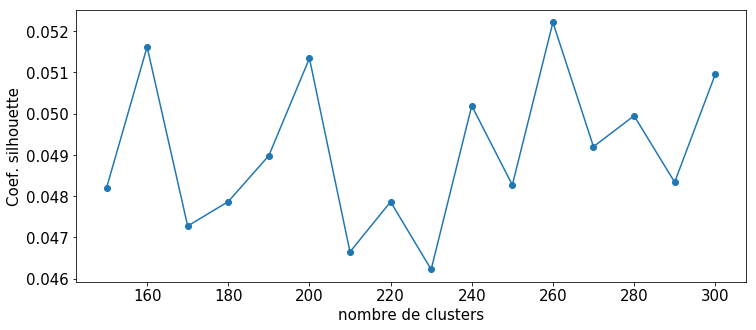

In [42]:
# La recherche du k optimal se fait avec les descripteurs des 70 images de la  'little_list'

from sklearn.cluster import KMeans
from sklearn import cluster, metrics


print("\n\nTemps estimé :  247 secondes\n")

X = images_70_array
l_range = [150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300]      # 230 <- meilleur k
nb_clusters = []
silhouettes = []

for num_clusters in l_range:
    cls = cluster.KMeans(n_clusters=num_clusters, n_init=10, init='k-means++')
    cls.fit(X)
    silh = metrics.silhouette_score(X, cls.labels_)
    silhouettes.append(silh)
    
fig = plt.figure(figsize=(12, 5))

plt.plot(l_range, silhouettes, marker='o')
plt.xlabel('nombre de clusters')
plt.ylabel('Coef. silhouette')
plt.savefig( "silhouette.png", dpi=50 )
plt.show()


### Création d'un dictionnaire de descripteurs des 1050 images

In [32]:
# Maintenant que l'on a notre 'k optimal', on va pouvoir classer les 1050 images.

import os


dict_des = {}   # dictionnaire des descripteurs  (UNE image contient un ensemble de desccripteurs)
img_no_kp = []
path_img = "./images_sift/"

sift = cv.SIFT_create()

for i in flipkart_img.index:

    img_name = os.path.join(path_img, flipkart_img["image"][i])
    img  = cv.imread(img_name)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray,None)   # détection des Key Points et création d'autant de descripteurs pour UNE image

    if not(kp):
        print("image",i,"sans Key Point")
        img_no_kp.append(i)
    else:
        print("Image :", i," -> Nbr descripteurs =", des.shape[0])
        dict_des[str(i)] = des

# Suppression des images sans Key Point dans le dataframe
if img_no_kp:
    flipkart_img.drop(img_no_kp, inplace=True)
    print("Images sans Key Point :", img_no_kp)

print("Taille du dictionnaire:", len(dict_des))   # 1050 entrées - (images sans Key Point)


Image : 0  -> Nbr descripteurs = 181
Image : 1  -> Nbr descripteurs = 115
Image : 2  -> Nbr descripteurs = 229
Image : 3  -> Nbr descripteurs = 208
Image : 4  -> Nbr descripteurs = 176
Image : 5  -> Nbr descripteurs = 148
Image : 6  -> Nbr descripteurs = 145
Image : 7  -> Nbr descripteurs = 145
Image : 8  -> Nbr descripteurs = 120
Image : 9  -> Nbr descripteurs = 201
Image : 10  -> Nbr descripteurs = 106
Image : 11  -> Nbr descripteurs = 139
Image : 12  -> Nbr descripteurs = 130
Image : 13  -> Nbr descripteurs = 116
Image : 14  -> Nbr descripteurs = 91
Image : 15  -> Nbr descripteurs = 74
Image : 16  -> Nbr descripteurs = 89
Image : 17  -> Nbr descripteurs = 27
Image : 18  -> Nbr descripteurs = 119
Image : 19  -> Nbr descripteurs = 73
Image : 20  -> Nbr descripteurs = 164
Image : 21  -> Nbr descripteurs = 341
Image : 22  -> Nbr descripteurs = 114
Image : 23  -> Nbr descripteurs = 190
Image : 24  -> Nbr descripteurs = 171
Image : 25  -> Nbr descripteurs = 139
Image : 26  -> Nbr descript

Image : 426  -> Nbr descripteurs = 29
Image : 427  -> Nbr descripteurs = 72
Image : 428  -> Nbr descripteurs = 168
Image : 429  -> Nbr descripteurs = 72
Image : 430  -> Nbr descripteurs = 224
Image : 431  -> Nbr descripteurs = 72
Image : 432  -> Nbr descripteurs = 72
Image : 433  -> Nbr descripteurs = 72
Image : 434  -> Nbr descripteurs = 72
Image : 435  -> Nbr descripteurs = 72
Image : 436  -> Nbr descripteurs = 67
Image : 437  -> Nbr descripteurs = 192
Image : 438  -> Nbr descripteurs = 122
Image : 439  -> Nbr descripteurs = 210
Image : 440  -> Nbr descripteurs = 72
Image : 441  -> Nbr descripteurs = 81
Image : 442  -> Nbr descripteurs = 57
Image : 443  -> Nbr descripteurs = 214
Image : 444  -> Nbr descripteurs = 127
Image : 445  -> Nbr descripteurs = 82
Image : 446  -> Nbr descripteurs = 107
Image : 447  -> Nbr descripteurs = 135
Image : 448  -> Nbr descripteurs = 89
Image : 449  -> Nbr descripteurs = 95
Image : 450  -> Nbr descripteurs = 81
Image : 451  -> Nbr descripteurs = 102
Im

Image : 850  -> Nbr descripteurs = 33
Image : 851  -> Nbr descripteurs = 9
Image : 852  -> Nbr descripteurs = 27
Image : 853  -> Nbr descripteurs = 38
Image : 854  -> Nbr descripteurs = 49
Image : 855  -> Nbr descripteurs = 21
Image : 856  -> Nbr descripteurs = 44
Image : 857  -> Nbr descripteurs = 110
Image : 858  -> Nbr descripteurs = 95
Image : 859  -> Nbr descripteurs = 18
Image : 860  -> Nbr descripteurs = 194
Image : 861  -> Nbr descripteurs = 72
Image : 862  -> Nbr descripteurs = 36
Image : 863  -> Nbr descripteurs = 233
Image : 864  -> Nbr descripteurs = 57
Image : 865  -> Nbr descripteurs = 120
Image : 866  -> Nbr descripteurs = 241
Image : 867  -> Nbr descripteurs = 41
Image : 868  -> Nbr descripteurs = 74
Image : 869  -> Nbr descripteurs = 334
Image : 870  -> Nbr descripteurs = 58
Image : 871  -> Nbr descripteurs = 131
Image : 872  -> Nbr descripteurs = 69
Image : 873  -> Nbr descripteurs = 488
Image : 874  -> Nbr descripteurs = 106
Image : 875  -> Nbr descripteurs = 351
Ima

In [33]:
# Conversion du dictionnaire des descripteurs de toutes les images (1050) -> array.
images_1050_array = dict2numpy(dict_des)
print(images_1050_array.shape)


(136925, 128)


### Classification des descripteurs

In [24]:
from sklearn.cluster import KMeans
from sklearn import cluster, metrics


print("\n\nTemps estimé :  701 secondes\n")

nclusters = 230    # 230 classes de descripteurs

km = KMeans(n_clusters=nclusters, init='k-means++')
km.fit(images_1050_array)
clusters_desc = km.labels_




Temps estimé :  701 secondes



### Constitution des histogrammes de descripteurs

In [25]:
# Distribution des classes de descripteurs par image

print("\n\nTemps estimé :  12 secondes\n")

bins  = range(1, nclusters+2)
hists = np.zeros((0, nclusters))    # tableau vide de 'nclusters' colonnes
start = 0

for key in dict_des.keys():                               # une clé => une image
    
    descripts = dict_des[key]                             # descripteurs d'UNE image
    print("Image", key,"-> Nb descripteurs =", descripts.shape[0])
    nbDescript = descripts.shape[0]                       # nombre de descripteurs pour UNE image
    
    clusters_img = clusters_desc[start:start+nbDescript]  # classes de descripteurs de cette image
    #print("[",start,":", start+nbDescript,"]")
    start += nbDescript

    hist, bins = np.histogram(clusters_img, bins)         # distribution des classes de descripteurs sur les bins de 1 à 230
    hists = np.vstack((hists, hist))

print("Nombre d'histogrammes :", len(hists))



Temps estimé :  12 secondes

Image 0 -> Nb descripteurs = 181
[ 0 : 181 ]
Image 1 -> Nb descripteurs = 115
[ 181 : 296 ]
Image 2 -> Nb descripteurs = 229
[ 296 : 525 ]
Image 3 -> Nb descripteurs = 208
[ 525 : 733 ]
Image 4 -> Nb descripteurs = 176
[ 733 : 909 ]
Image 5 -> Nb descripteurs = 148
[ 909 : 1057 ]
Image 6 -> Nb descripteurs = 145
[ 1057 : 1202 ]
Image 7 -> Nb descripteurs = 145
[ 1202 : 1347 ]
Image 8 -> Nb descripteurs = 120
[ 1347 : 1467 ]
Image 9 -> Nb descripteurs = 201
[ 1467 : 1668 ]
Image 10 -> Nb descripteurs = 106
[ 1668 : 1774 ]
Image 11 -> Nb descripteurs = 139
[ 1774 : 1913 ]
Image 12 -> Nb descripteurs = 130
[ 1913 : 2043 ]
Image 13 -> Nb descripteurs = 116
[ 2043 : 2159 ]
Image 14 -> Nb descripteurs = 91
[ 2159 : 2250 ]
Image 15 -> Nb descripteurs = 74
[ 2250 : 2324 ]
Image 16 -> Nb descripteurs = 89
[ 2324 : 2413 ]
Image 17 -> Nb descripteurs = 27
[ 2413 : 2440 ]
Image 18 -> Nb descripteurs = 119
[ 2440 : 2559 ]
Image 19 -> Nb descripteurs = 73
[ 2559 : 2632

Image 315 -> Nb descripteurs = 199
[ 43052 : 43251 ]
Image 316 -> Nb descripteurs = 145
[ 43251 : 43396 ]
Image 317 -> Nb descripteurs = 175
[ 43396 : 43571 ]
Image 318 -> Nb descripteurs = 46
[ 43571 : 43617 ]
Image 319 -> Nb descripteurs = 143
[ 43617 : 43760 ]
Image 320 -> Nb descripteurs = 170
[ 43760 : 43930 ]
Image 321 -> Nb descripteurs = 22
[ 43930 : 43952 ]
Image 322 -> Nb descripteurs = 127
[ 43952 : 44079 ]
Image 323 -> Nb descripteurs = 118
[ 44079 : 44197 ]
Image 324 -> Nb descripteurs = 14
[ 44197 : 44211 ]
Image 325 -> Nb descripteurs = 95
[ 44211 : 44306 ]
Image 326 -> Nb descripteurs = 74
[ 44306 : 44380 ]
Image 327 -> Nb descripteurs = 28
[ 44380 : 44408 ]
Image 328 -> Nb descripteurs = 159
[ 44408 : 44567 ]
Image 329 -> Nb descripteurs = 76
[ 44567 : 44643 ]
Image 330 -> Nb descripteurs = 63
[ 44643 : 44706 ]
Image 331 -> Nb descripteurs = 138
[ 44706 : 44844 ]
Image 332 -> Nb descripteurs = 59
[ 44844 : 44903 ]
Image 333 -> Nb descripteurs = 72
[ 44903 : 44975 ]
Ima

Image 628 -> Nb descripteurs = 67
[ 77544 : 77611 ]
Image 629 -> Nb descripteurs = 124
[ 77611 : 77735 ]
Image 630 -> Nb descripteurs = 312
[ 77735 : 78047 ]
Image 631 -> Nb descripteurs = 164
[ 78047 : 78211 ]
Image 632 -> Nb descripteurs = 46
[ 78211 : 78257 ]
Image 633 -> Nb descripteurs = 33
[ 78257 : 78290 ]
Image 634 -> Nb descripteurs = 417
[ 78290 : 78707 ]
Image 635 -> Nb descripteurs = 40
[ 78707 : 78747 ]
Image 636 -> Nb descripteurs = 94
[ 78747 : 78841 ]
Image 637 -> Nb descripteurs = 216
[ 78841 : 79057 ]
Image 638 -> Nb descripteurs = 60
[ 79057 : 79117 ]
Image 639 -> Nb descripteurs = 207
[ 79117 : 79324 ]
Image 640 -> Nb descripteurs = 180
[ 79324 : 79504 ]
Image 641 -> Nb descripteurs = 359
[ 79504 : 79863 ]
Image 642 -> Nb descripteurs = 33
[ 79863 : 79896 ]
Image 643 -> Nb descripteurs = 174
[ 79896 : 80070 ]
Image 644 -> Nb descripteurs = 158
[ 80070 : 80228 ]
Image 645 -> Nb descripteurs = 134
[ 80228 : 80362 ]
Image 646 -> Nb descripteurs = 157
[ 80362 : 80519 ]


[ 119805 : 119987 ]
Image 935 -> Nb descripteurs = 48
[ 119987 : 120035 ]
Image 936 -> Nb descripteurs = 15
[ 120035 : 120050 ]
Image 937 -> Nb descripteurs = 173
[ 120050 : 120223 ]
Image 938 -> Nb descripteurs = 86
[ 120223 : 120309 ]
Image 939 -> Nb descripteurs = 274
[ 120309 : 120583 ]
Image 940 -> Nb descripteurs = 51
[ 120583 : 120634 ]
Image 941 -> Nb descripteurs = 153
[ 120634 : 120787 ]
Image 942 -> Nb descripteurs = 264
[ 120787 : 121051 ]
Image 943 -> Nb descripteurs = 194
[ 121051 : 121245 ]
Image 944 -> Nb descripteurs = 275
[ 121245 : 121520 ]
Image 945 -> Nb descripteurs = 243
[ 121520 : 121763 ]
Image 946 -> Nb descripteurs = 96
[ 121763 : 121859 ]
Image 947 -> Nb descripteurs = 235
[ 121859 : 122094 ]
Image 948 -> Nb descripteurs = 72
[ 122094 : 122166 ]
Image 949 -> Nb descripteurs = 159
[ 122166 : 122325 ]
Image 950 -> Nb descripteurs = 200
[ 122325 : 122525 ]
Image 951 -> Nb descripteurs = 81
[ 122525 : 122606 ]
Image 952 -> Nb descripteurs = 221
[ 122606 : 122827

### Classifications des images en 7 catégories

In [27]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler


km = KMeans(n_clusters=7)    # 7 clusters souhaités, pour les 7 catégories
km.fit(hists)

# Récupération des clusters attribués à chaque individu
clusters_sift = km.labels_

print("Clusters SIFT :", set(clusters_sift))

#  Association du cluster au produit :
flipkart_img['cluster'] = clusters_sift
flipkart_img.head(3)


Clusters SIFT : {0, 1, 2, 3, 4, 5, 6}


,categ,product,category,image,cluster
0,4,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,0.jpg,2
1,0,Sathiyas Cotton Bath Towel,Baby Care,1.jpg,5
2,0,Eurospa Cotton Terry Face Towel Set,Baby Care,2.jpg,2


In [60]:
# Affichage du nombre de Produits pour chaque cluster

categories = flipkart_img['category']

# Dataframe associant le Client au cluster :
categCluster = pd.DataFrame({"Categorie": categories, "cluster": clusters_sift})   # Catégorie - cluster

# Dataframe du nombre de produits par cluster :
categCluster['Produit'] = 1
cumul_km_sift = categCluster.groupby(['cluster']).sum().reset_index()
cumul_km_sift.columns = ['cluster', 'nb_produits']
print(cumul_km_sift)


   cluster  nb_produits
0        0            7
1        1            1
2        2          334
3        3            6
4        4            6
5        5          688
6        6            6


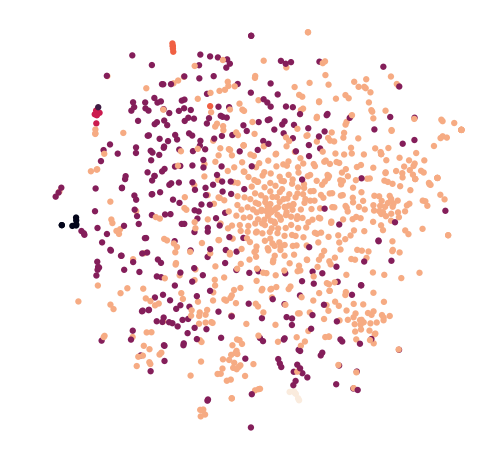

In [61]:
# Projection des produits avec t-SNE (t-Stochastic Neighbour Embedding)

from sklearn.manifold import TSNE

def fashion_scatter(x):
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=clusters_sift)
    ax.axis('off')
    ax.axis('tight')
    plt.show()

tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(hists)
fashion_scatter(X_2d)

### Matching SIFT - Classification humaine

In [62]:
from sklearn import metrics

rand_score = metrics.adjusted_rand_score(flipkart_img['category'], flipkart_img['cluster'])      
print("Rand Score ajusté =\n", rand_score)

# nb_clusters    rand
# ---------------------
# 400            0.0229
# 300            0.0344
# 250            0.0248
# 230            0.0287
# 200            0.0251
# 180            0.0234

Rand Score ajusté =
 0.02477629722736642


### Matrice de confusion

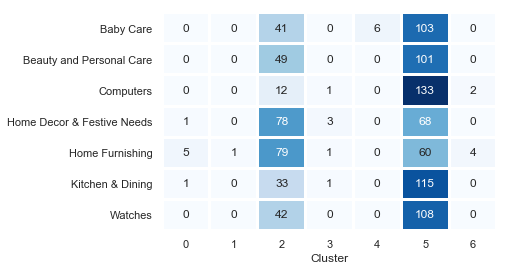

In [59]:
# Autre évaluation de notre modele :   Evaluation de la qualité d'un modèle de classification

from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set()
cm = confusion_matrix(flipkart_img['categ'], flipkart_img['cluster'])

df_cm = pd.DataFrame(cm, columns=np.unique(flipkart_img['categ']), index = np.unique(flipkart_img['category']))
df_cm.columns.name = 'Cluster'

ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=2, cbar=False)


## CNN - Reseau de Neurones convolutifs

In [ ]:
Projet6_CNN.ipynb  --> à exécuter sous Google Colab, merci.
